# Домашнее задание 1. BlackJack & Dustin Hoffman

## Выполнил: Гудков Иван, MADE-DS-31


In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from IPython.display import clear_output

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

## Часть 1. Базовая стратегия. Q-обучение на стандартных правилах

Возьмем базовую версию Blackjack без natural blackjack, реализованную в OpenAI Gym и рассмотрим самую простую стратегию, когда мы останавливаемся, если сумма очков равна 19, 20 или 21.

In [2]:
def reward_by_strategy_function(env):
    cur_state = env.reset()
    game_finished = False
    
    while not game_finished:
        if cur_state[0] < 19:
            cur_state, reward, game_finished, _ = env.step(1)
        else:
            cur_state, reward, game_finished, _ = env.step(0)
    return reward

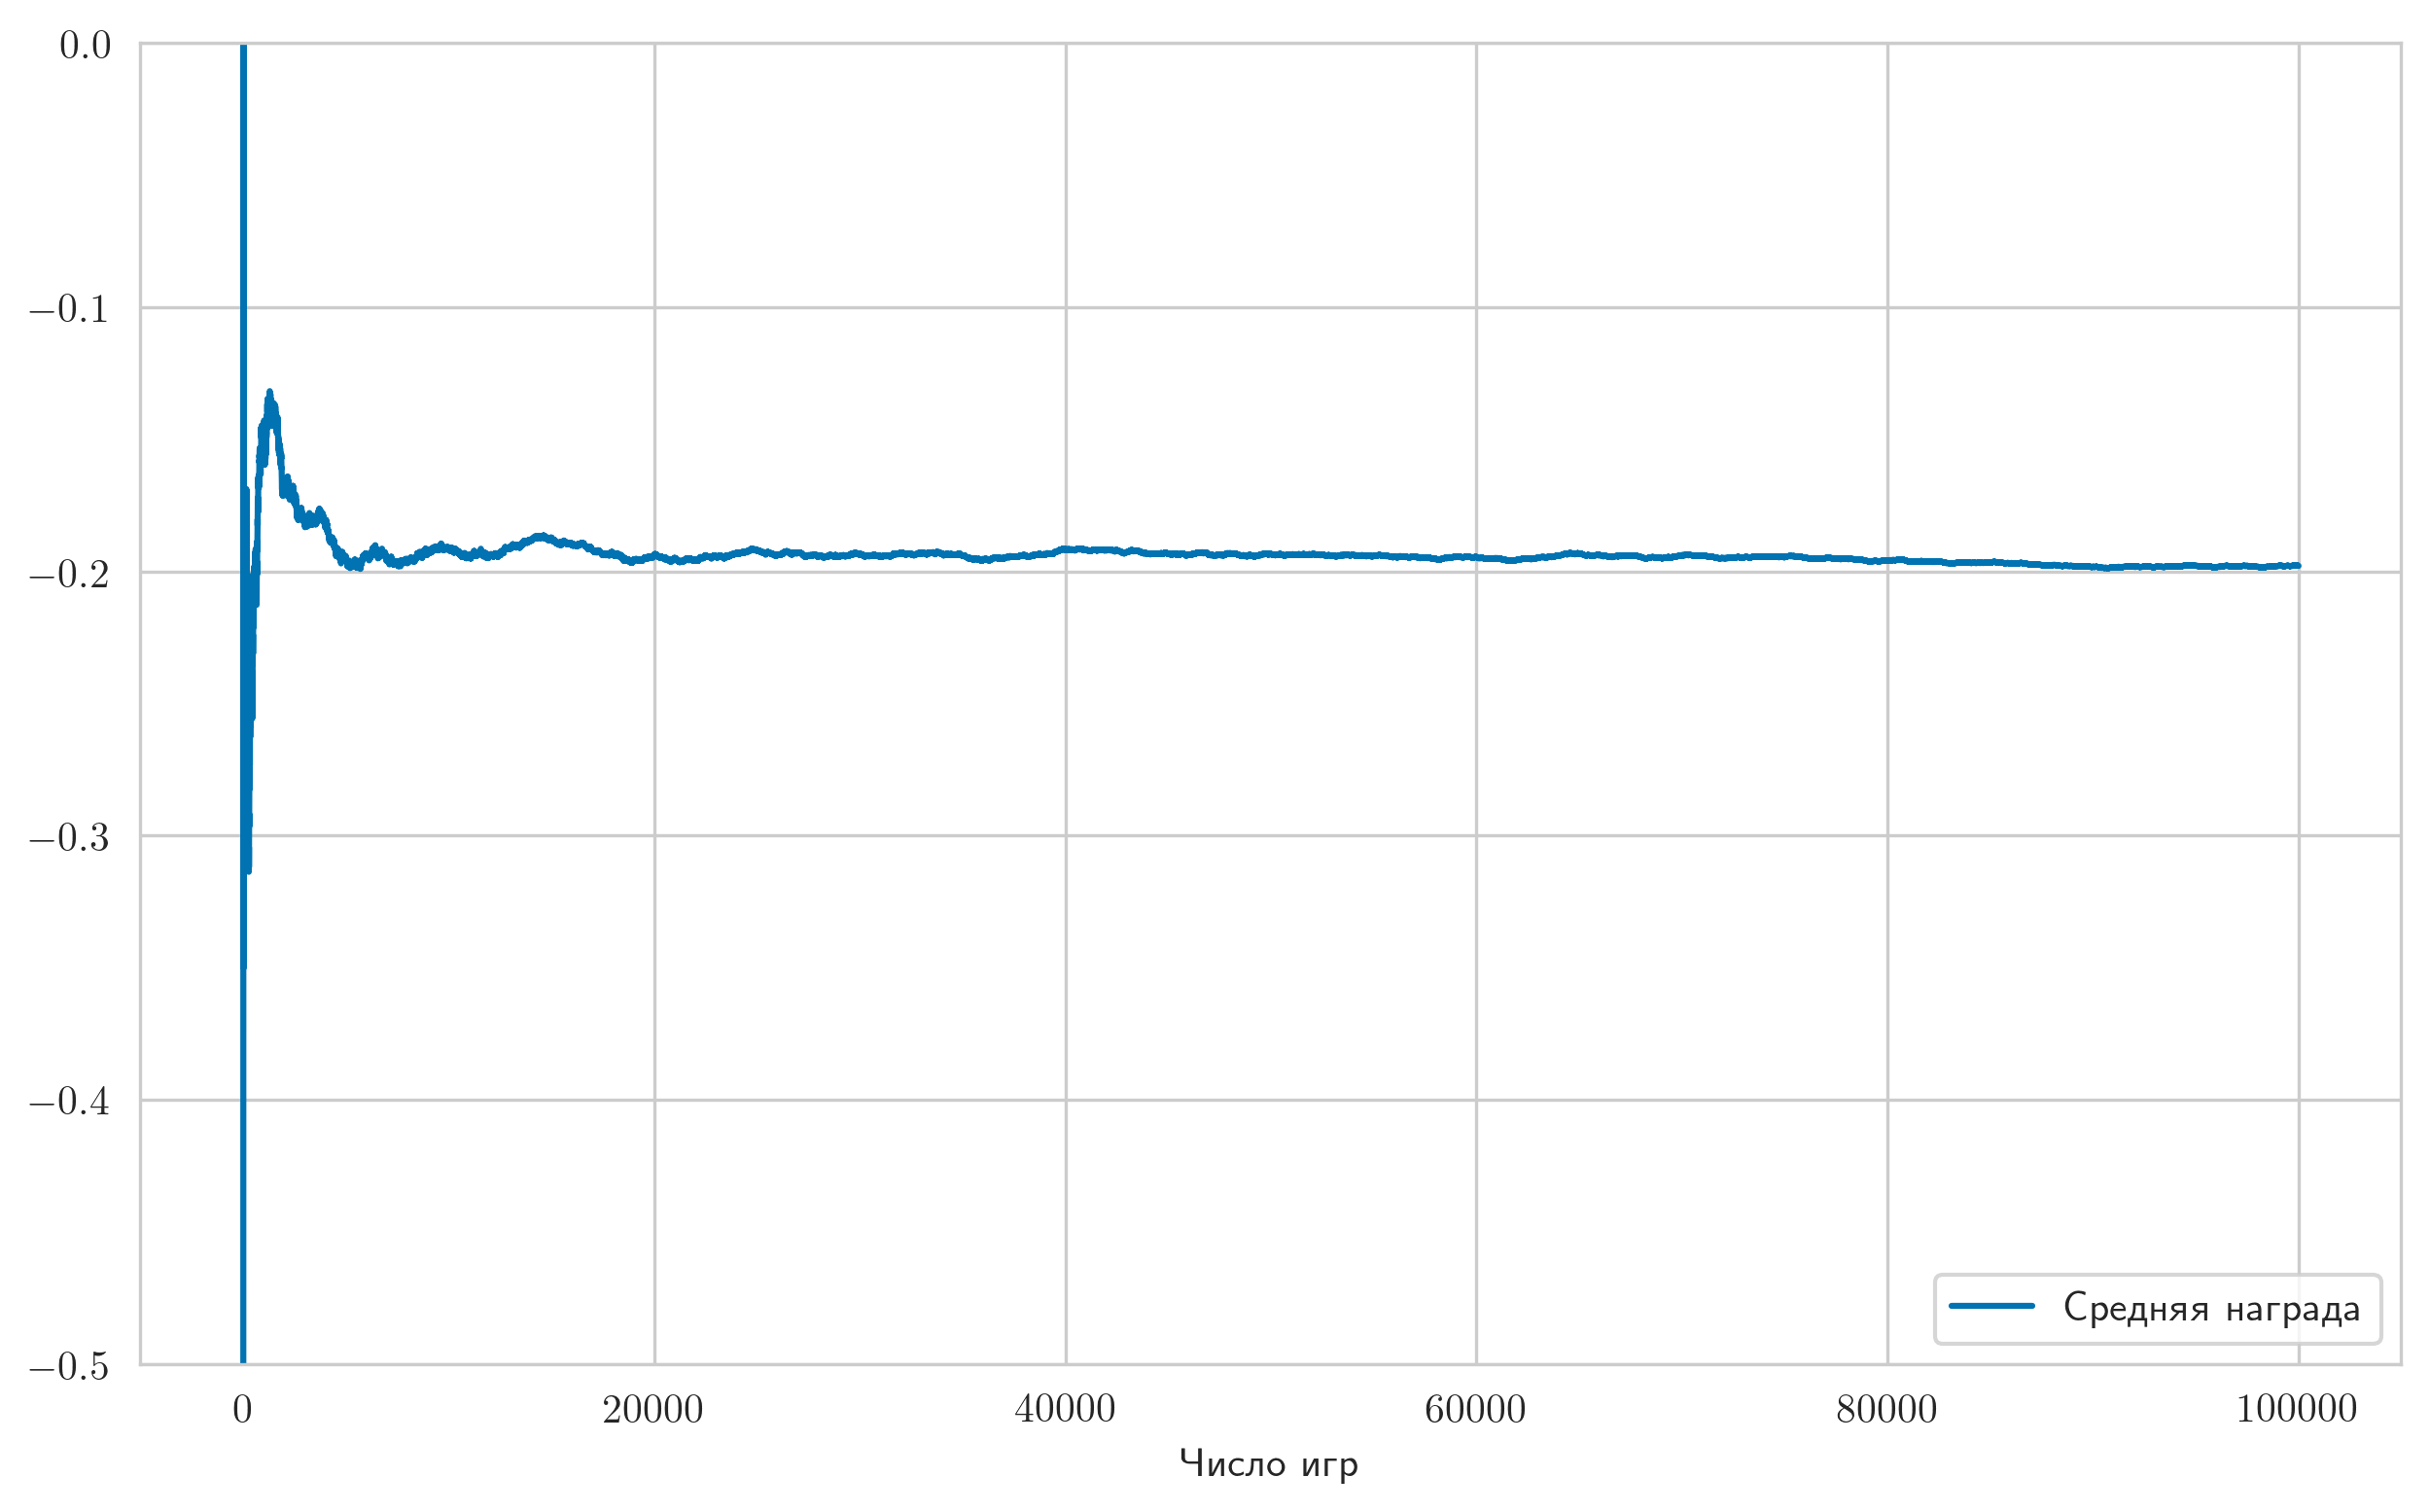

In [3]:
N_games = 100000
def plot_results_using_strategy(env, reward_by_strategy):
    avg_results = [0]
    for game_i in range(N_games):
        reward = reward_by_strategy(env)
        avg_results.append((avg_results[-1] * game_i + reward) / (game_i + 1))
                           
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    line = ax.plot(np.arange(N_games), avg_results[1:], label="Средняя награда", color="C0")
    ax.legend(loc="lower right")
    ax.set_ylim((-0.5, 0.0))
    ax.set_xlabel('Число игр')
    return fig, ax

env = gym.make('Blackjack-v1')
fig, ax = plot_results_using_strategy(env, reward_by_strategy_function)
env.close()

Видно, что с самой простой стратегией на каждой раздаче в среднем мы проигрываем 0.2 у.е.

Попробуем с помощью Q-обучений найти оптимальную стратегию и улушить наш выигрыш.

In [4]:
def get_random_Q(env):
    Q = 2 * np.random.random(size=(env.observation_space[2].n, env.observation_space[1].n, env.observation_space[0].n, env.action_space.n)) - 1
    Q[:,:,22:] = 0.0
    return Q

In [5]:
Q = get_random_Q(env)
Q[0]

array([[[ 0.09747235,  0.91809703],
        [ 0.22072572,  0.24052538],
        [-0.63868207,  0.01946476],
        [-0.23019811,  0.49818876],
        [ 0.63852154, -0.870147  ],
        [ 0.5462228 , -0.75790003],
        [ 0.72129226,  0.6465457 ],
        [-0.64106945, -0.42645152],
        [-0.08098579, -0.7483422 ],
        [ 0.30245733, -0.17965527],
        [-0.85839599,  0.51943582],
        [-0.65090763, -0.1496462 ],
        [ 0.06299174, -0.29124293],
        [ 0.79875142,  0.33371532],
        [-0.5584036 ,  0.35119637],
        [-0.44237514, -0.52245707],
        [ 0.24842581,  0.18602046],
        [ 0.55209543,  0.08267249],
        [ 0.19789365, -0.54323693],
        [-0.56022465,  0.68771296],
        [ 0.20962569,  0.00635565],
        [-0.61739473,  0.51161605],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.   

In [6]:
Q.shape

(2, 11, 32, 2)

In [7]:
def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    init_state = env.reset()
    s = (1 if init_state[2] else 0, init_state[1], init_state[0])
    a = pi[1 if init_state[2] else 0, init_state[1], init_state[0]] if np.random.rand() > epsilon else env.action_space.sample()
    for _ in range(1000):
        observation, reward, done, info = env.step(a)
        s_prime = (1 if observation[2] else 0, observation[1], observation[0])
        a_prime = pi[1 if observation[2] else 0, observation[1], observation[0]] if np.random.rand() > epsilon else env.action_space.sample()
        Q[s[0], s[1], s[2], a] += alpha * (reward + gamma * np.max(Q[s_prime[0], s_prime[1], s_prime[2]]) - Q[s[0], s[1], s[2], a])
        s, a = s_prime, a_prime
        if done:
            break

In [8]:
def compute_policy_by_Q(env, Q, gamma=1.0):
    return np.argmax(Q, axis=-1)

In [9]:
def reward_by_strategy_matrix(env, pi):
    cur_state = env.reset()
    game_finished = False
    
    while not game_finished:
        cur_state, reward, game_finished, _ = env.step(pi[1 if cur_state[2] else 0, cur_state[1], cur_state[0]])
    return reward

### Эксперимент 1.
Зафиксируем параметры: gamma = 0.9, alpha = 0.1, epsilon = 0.1

300000  episodes completed


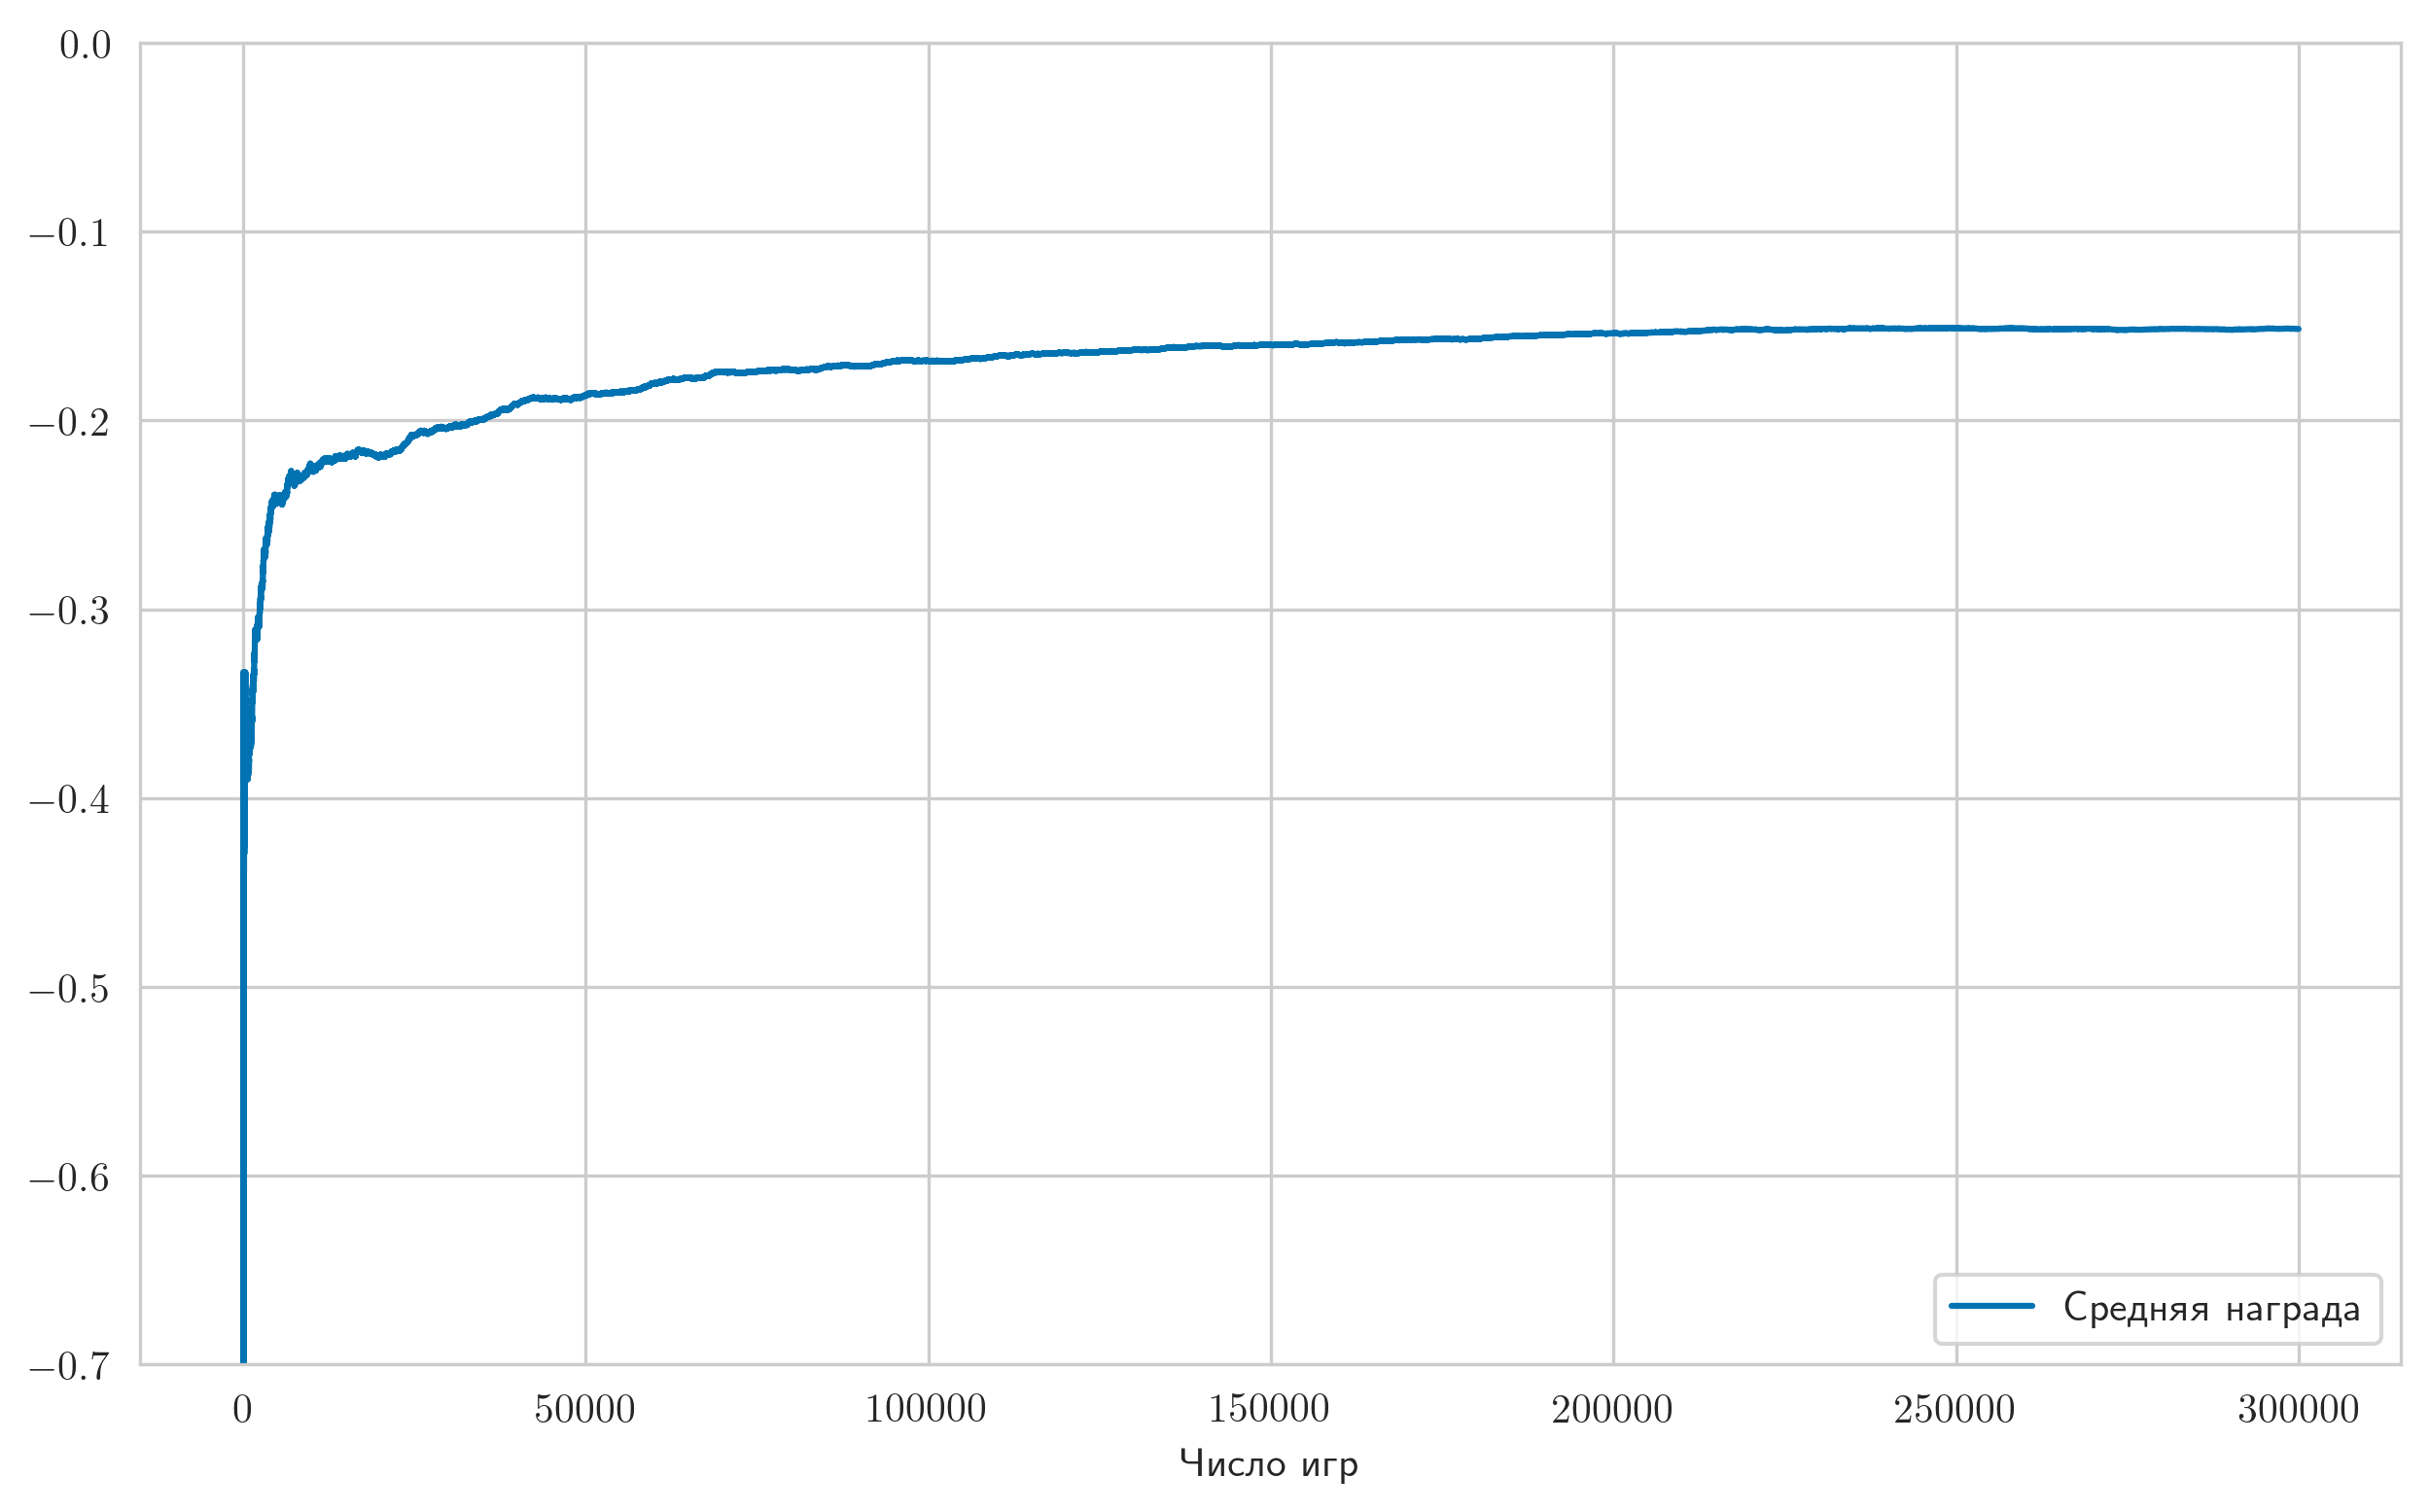

In [10]:
env = gym.make('Blackjack-v1')
total_episodes = 300000
gamma = 0.9
alpha = 0.1
eps = 0.1


Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)

avg_results = [0]
for n in range(total_episodes + 1):
    if n > 0 and n % 30000 == 0:
        clear_output(True)
        print(n, " episodes completed")
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        line = ax.plot(np.arange(n), avg_results[1:], label="Средняя награда", color="C0")
        ax.legend(loc="lower right")
        ax.set_ylim((-0.7, 0.0))
        ax.set_xlabel('Число игр')
        plt.show()
    Q_learning_episode(env, pi, Q, alpha=alpha, epsilon=eps, gamma=gamma)
    pi = compute_policy_by_Q(env, Q)
    reward = reward_by_strategy_matrix(env, pi)
    avg_results.append((avg_results[-1] * n + reward) / (n + 1))

env.close()

In [11]:
print("Mean_profit: ", avg_results[-1])

Mean_profit:  -0.1515428281905739


Результат уже гораздо лучше базовой стратегии. Попробуем еще поиграться с гиперпараметрами.

### Эксперимент 2.
gamma = 0.5, alpha = 0.05, epsilon = 0.2

300000  episodes completed


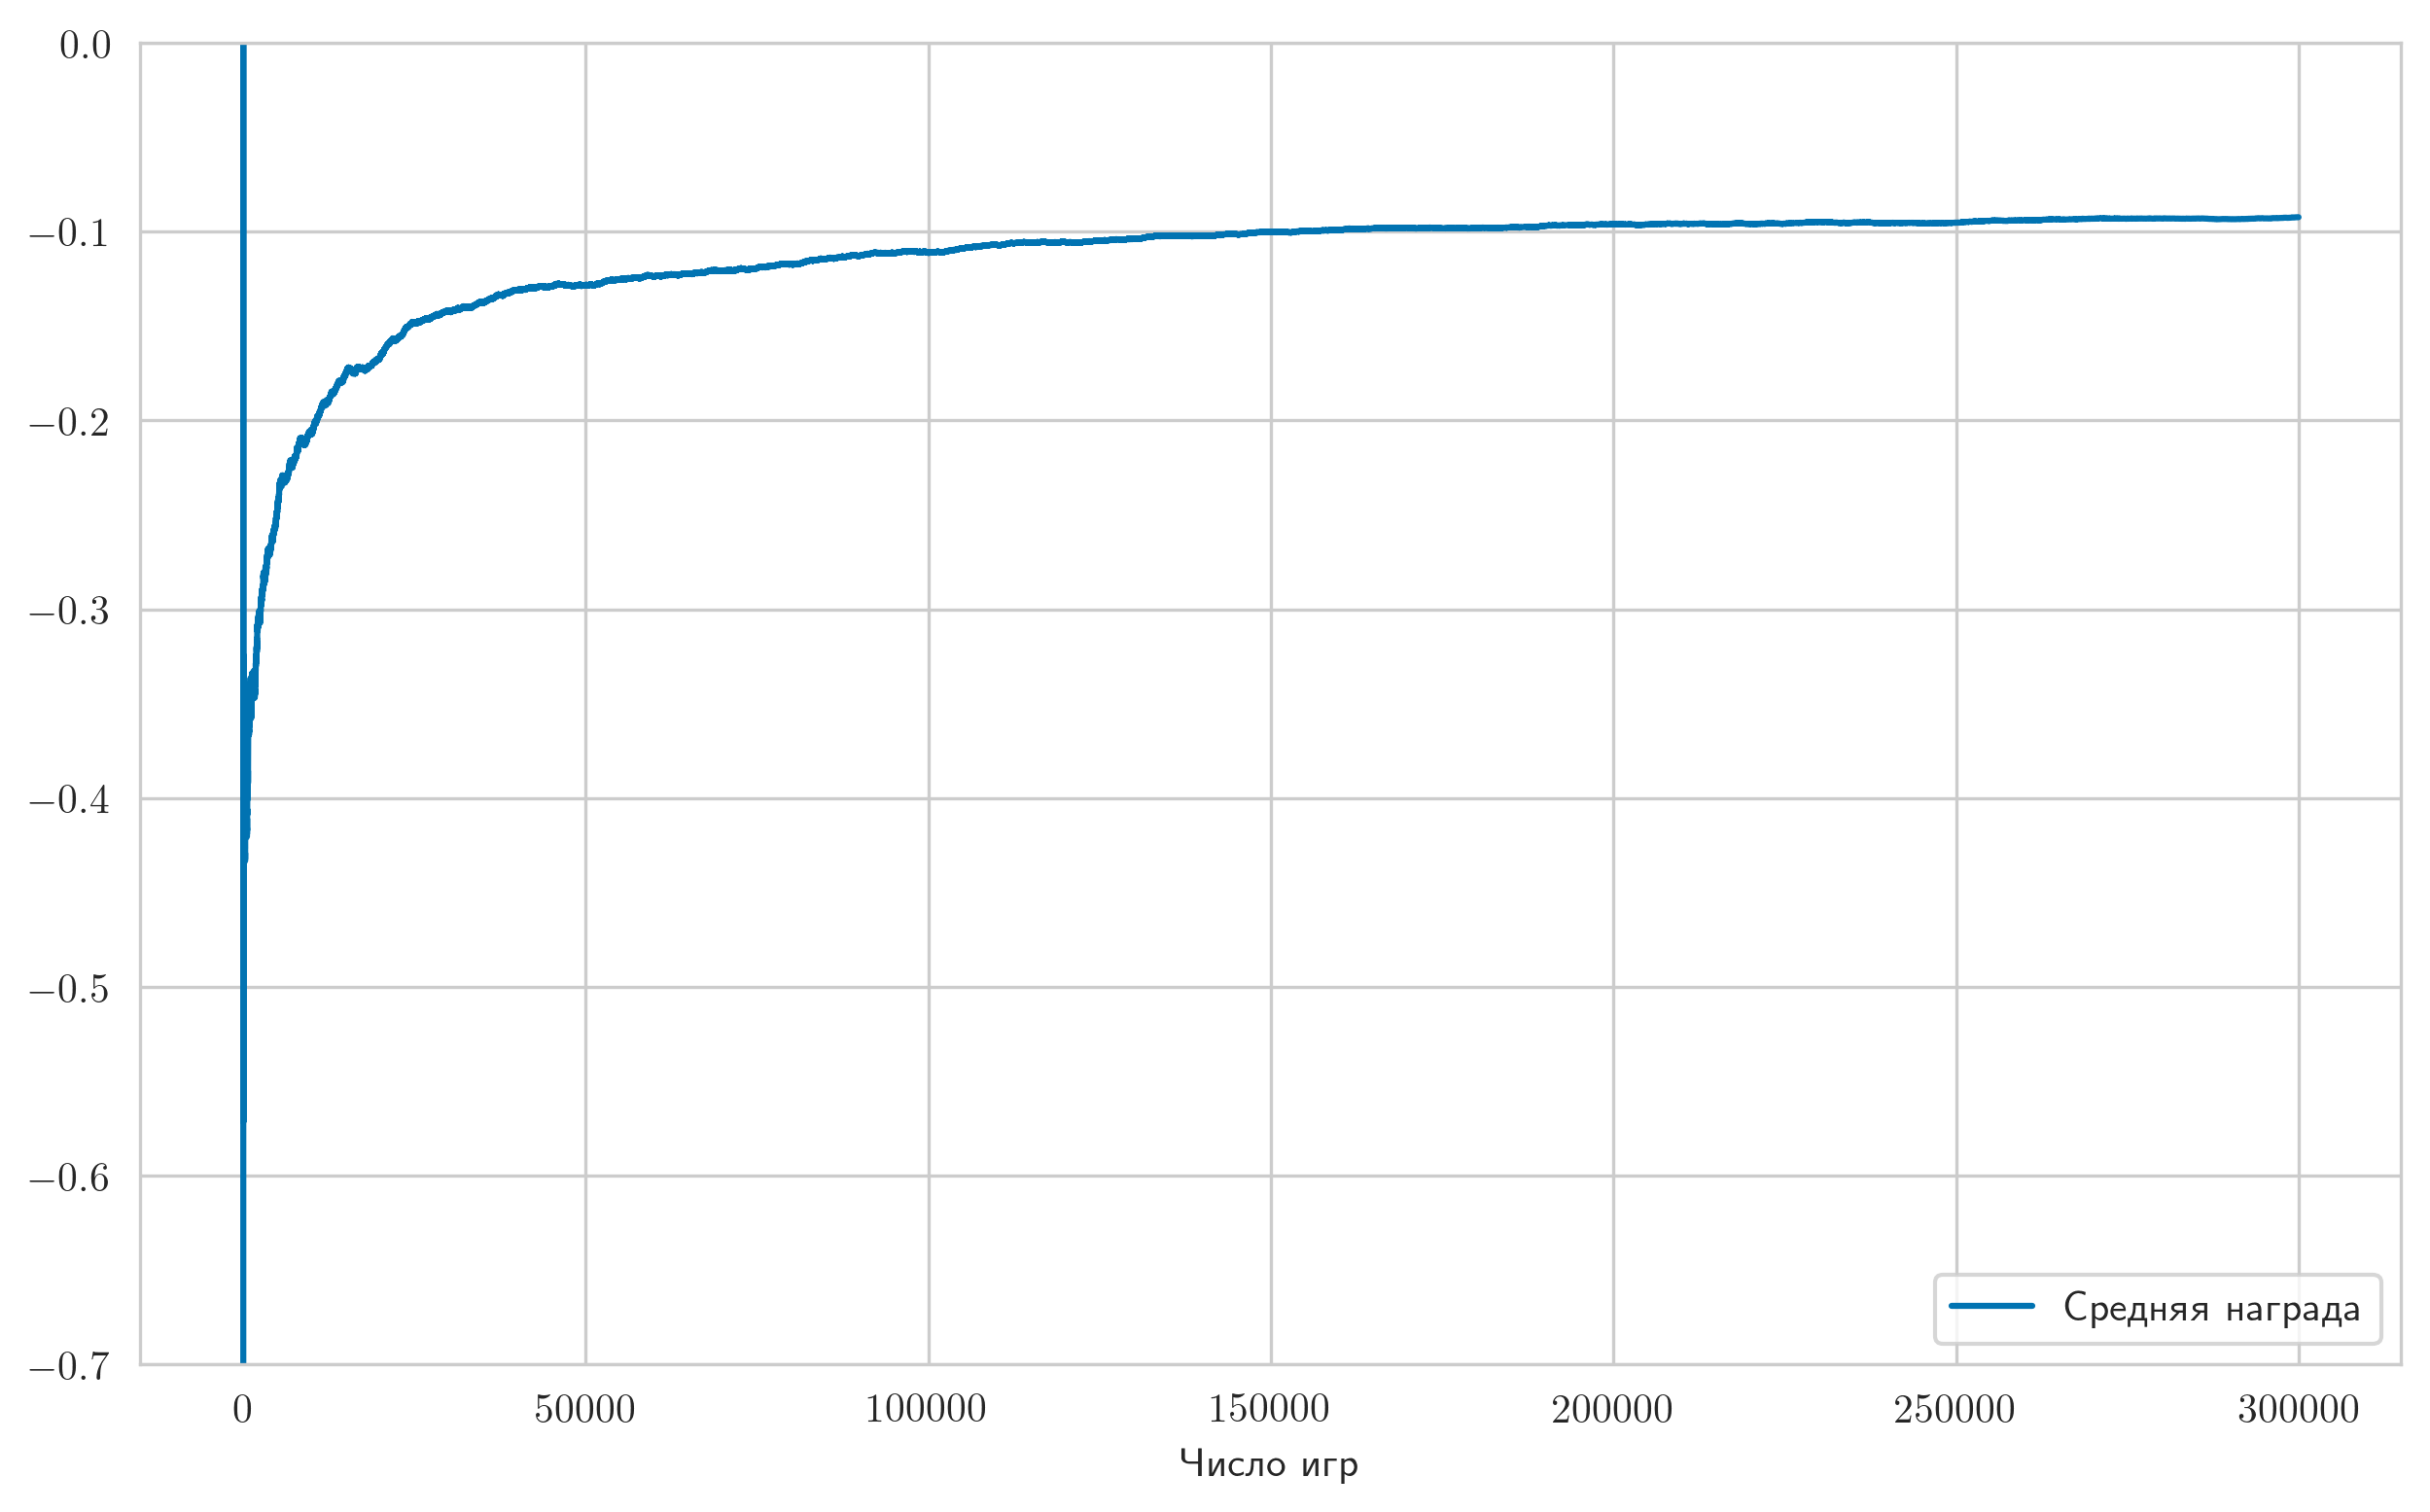

In [12]:
env = gym.make('Blackjack-v1')
total_episodes = 300000
gamma = 0.5
alpha = 0.05
eps = 0.2

Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)

avg_results = [0]
for n in range(total_episodes + 1):
    if n > 0 and n % 30000 == 0:
        clear_output(True)
        print(n, " episodes completed")
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        line = ax.plot(np.arange(n), avg_results[1:], label="Средняя награда", color="C0")
        ax.legend(loc="lower right")
        ax.set_ylim((-0.7, 0.0))
        ax.set_xlabel('Число игр')
        plt.show()
    Q_learning_episode(env, pi, Q, alpha=alpha, epsilon=eps, gamma=gamma)
    pi = compute_policy_by_Q(env, Q)
    reward = reward_by_strategy_matrix(env, pi)
    avg_results.append((avg_results[-1] * n + reward) / (n + 1))

env.close()

In [13]:
print("Mean_profit: ", avg_results[-1])

Mean_profit:  -0.09236302545658144


### Эксперимент 3. 
gamma = 0.1, alpha = 0.05, epsilon = 0.5

300000  episodes completed


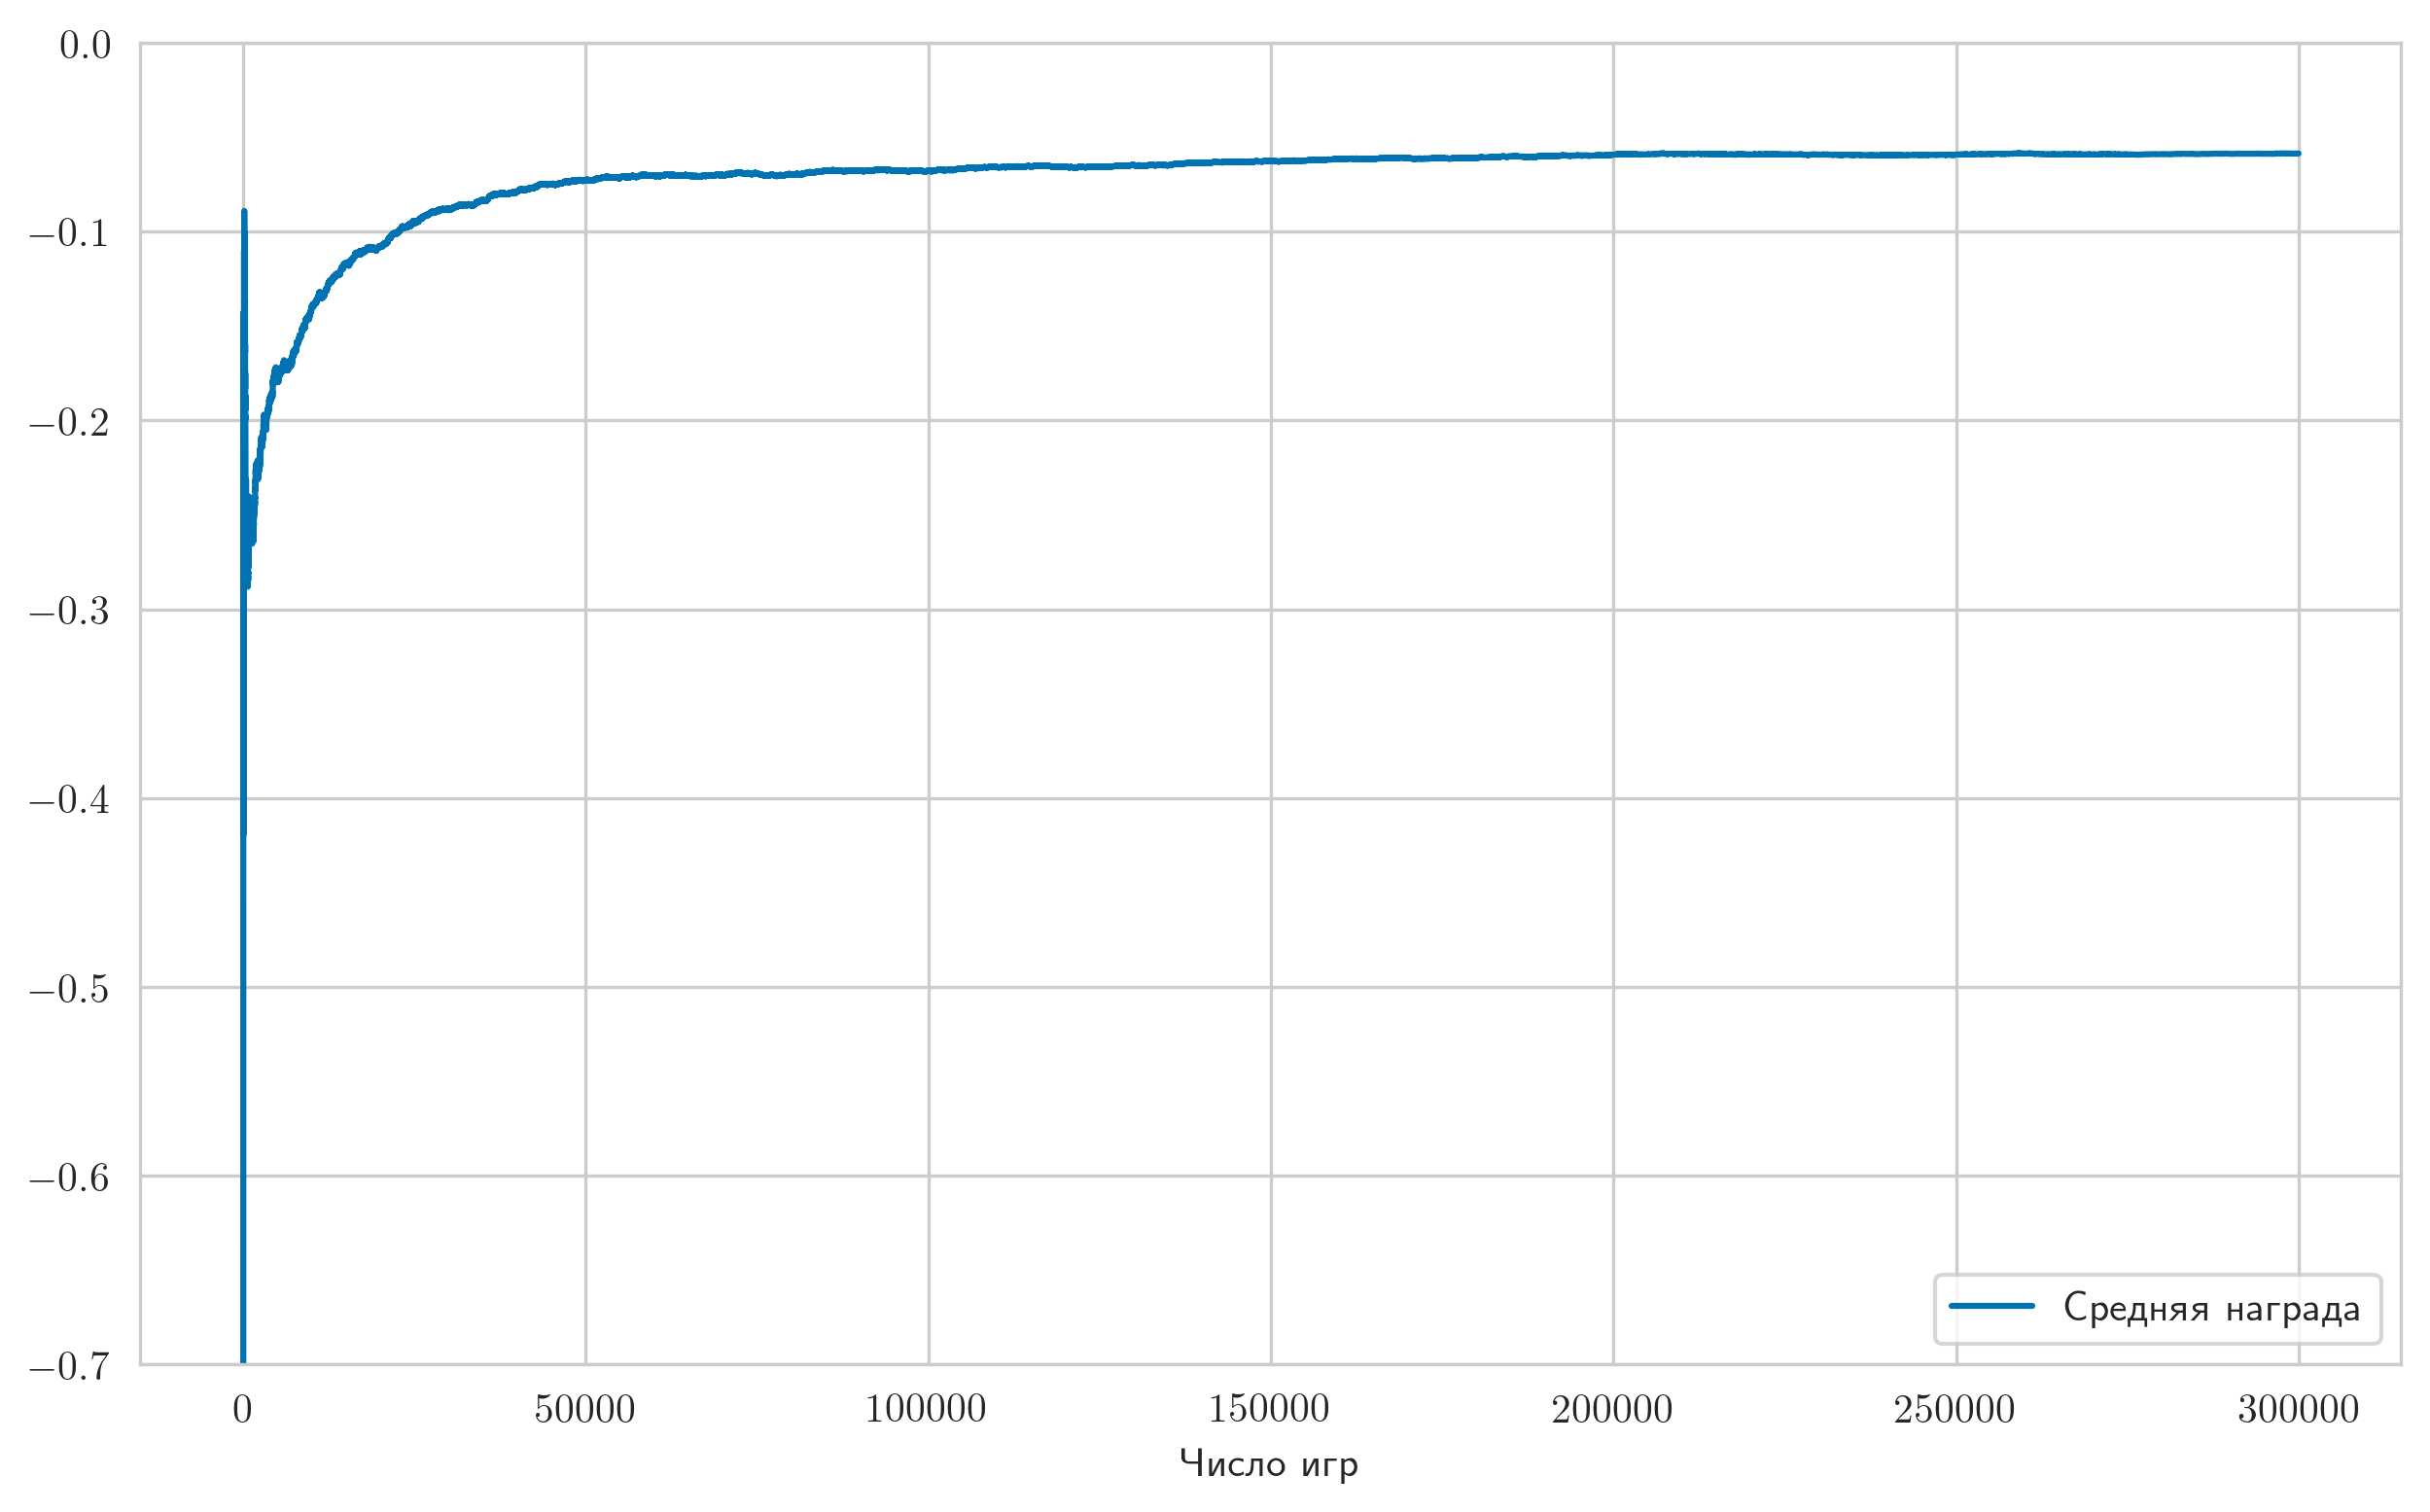

In [14]:
env = gym.make('Blackjack-v1')
total_episodes = 300000
gamma = 0.1
alpha = 0.05
eps = 0.5


Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)

avg_results = [0]
for n in range(total_episodes + 1):
    if n > 0 and n % 30000 == 0:
        clear_output(True)
        print(n, " episodes completed")
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        line = ax.plot(np.arange(n), avg_results[1:], label="Средняя награда", color="C0")
        ax.legend(loc="lower right")
        ax.set_ylim((-0.7, 0.0))
        ax.set_xlabel('Число игр')
        plt.show()
    Q_learning_episode(env, pi, Q, alpha=alpha, epsilon=eps, gamma=gamma)
    pi = compute_policy_by_Q(env, Q)
    reward = reward_by_strategy_matrix(env, pi)
    avg_results.append((avg_results[-1] * n + reward) / (n + 1))

env.close()

In [15]:
print("Mean_profit: ", avg_results[-1])

Mean_profit:  -0.05854313818953881


Отлично, проигрывать стали заметно меньше: примерно в 3.5 раза. Но казино по прежнему наживается на нашей стратегии. Попробуем поирать в другой блэкджек...

## Часть 2. Удваиваем ставки, господа!

Перепишем немного среду, добавив возможность удвоения ставки. Теперь у игрока три возможности. Попробуем обучить стратегию для такого блэкджека, когда на каждом шаге у игрока выбор не из двух альтернатив, а из трех.

In [16]:
import gym
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class DoubleBlackjackEnv(gym.Env):

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        else: # double: bid more - win more
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -2.0
            else:
                done = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [17]:
def get_random_Q(env):
    Q = 2 * np.random.random(size=(env.observation_space[2].n, env.observation_space[1].n, env.observation_space[0].n, env.action_space.n)) - 1
    Q[:,:,22:] = 0.0
    return Q

def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    init_state = env.reset()
    s = (1 if init_state[2] else 0, init_state[1], init_state[0])
    a = pi[1 if init_state[2] else 0, init_state[1], init_state[0]] if np.random.rand() > epsilon else env.action_space.sample()
    for _ in range(1000):
        observation, reward, done, info = env.step(a)
        s_prime = (1 if observation[2] else 0, observation[1], observation[0])
        a_prime = pi[1 if observation[2] else 0, observation[1], observation[0]] if np.random.rand() > epsilon else env.action_space.sample()
        Q[s[0], s[1], s[2], a] += alpha * (reward + gamma * np.max(Q[s_prime[0], s_prime[1], s_prime[2]]) - Q[s[0], s[1], s[2], a])
        s, a = s_prime, a_prime
        if done:
            break

def reward_by_strategy_matrix(env, pi):
    cur_state = env.reset()
    game_finished = False
    
    while not game_finished:
        cur_state, reward, game_finished, _ = env.step(pi[1 if cur_state[2] else 0, cur_state[1], cur_state[0]])
    return reward

## Эксперимент 1.
Зафиксируем параметры: gamma = 0.9, alpha = 0.1, epsilon = 0.1

300000  episodes completed


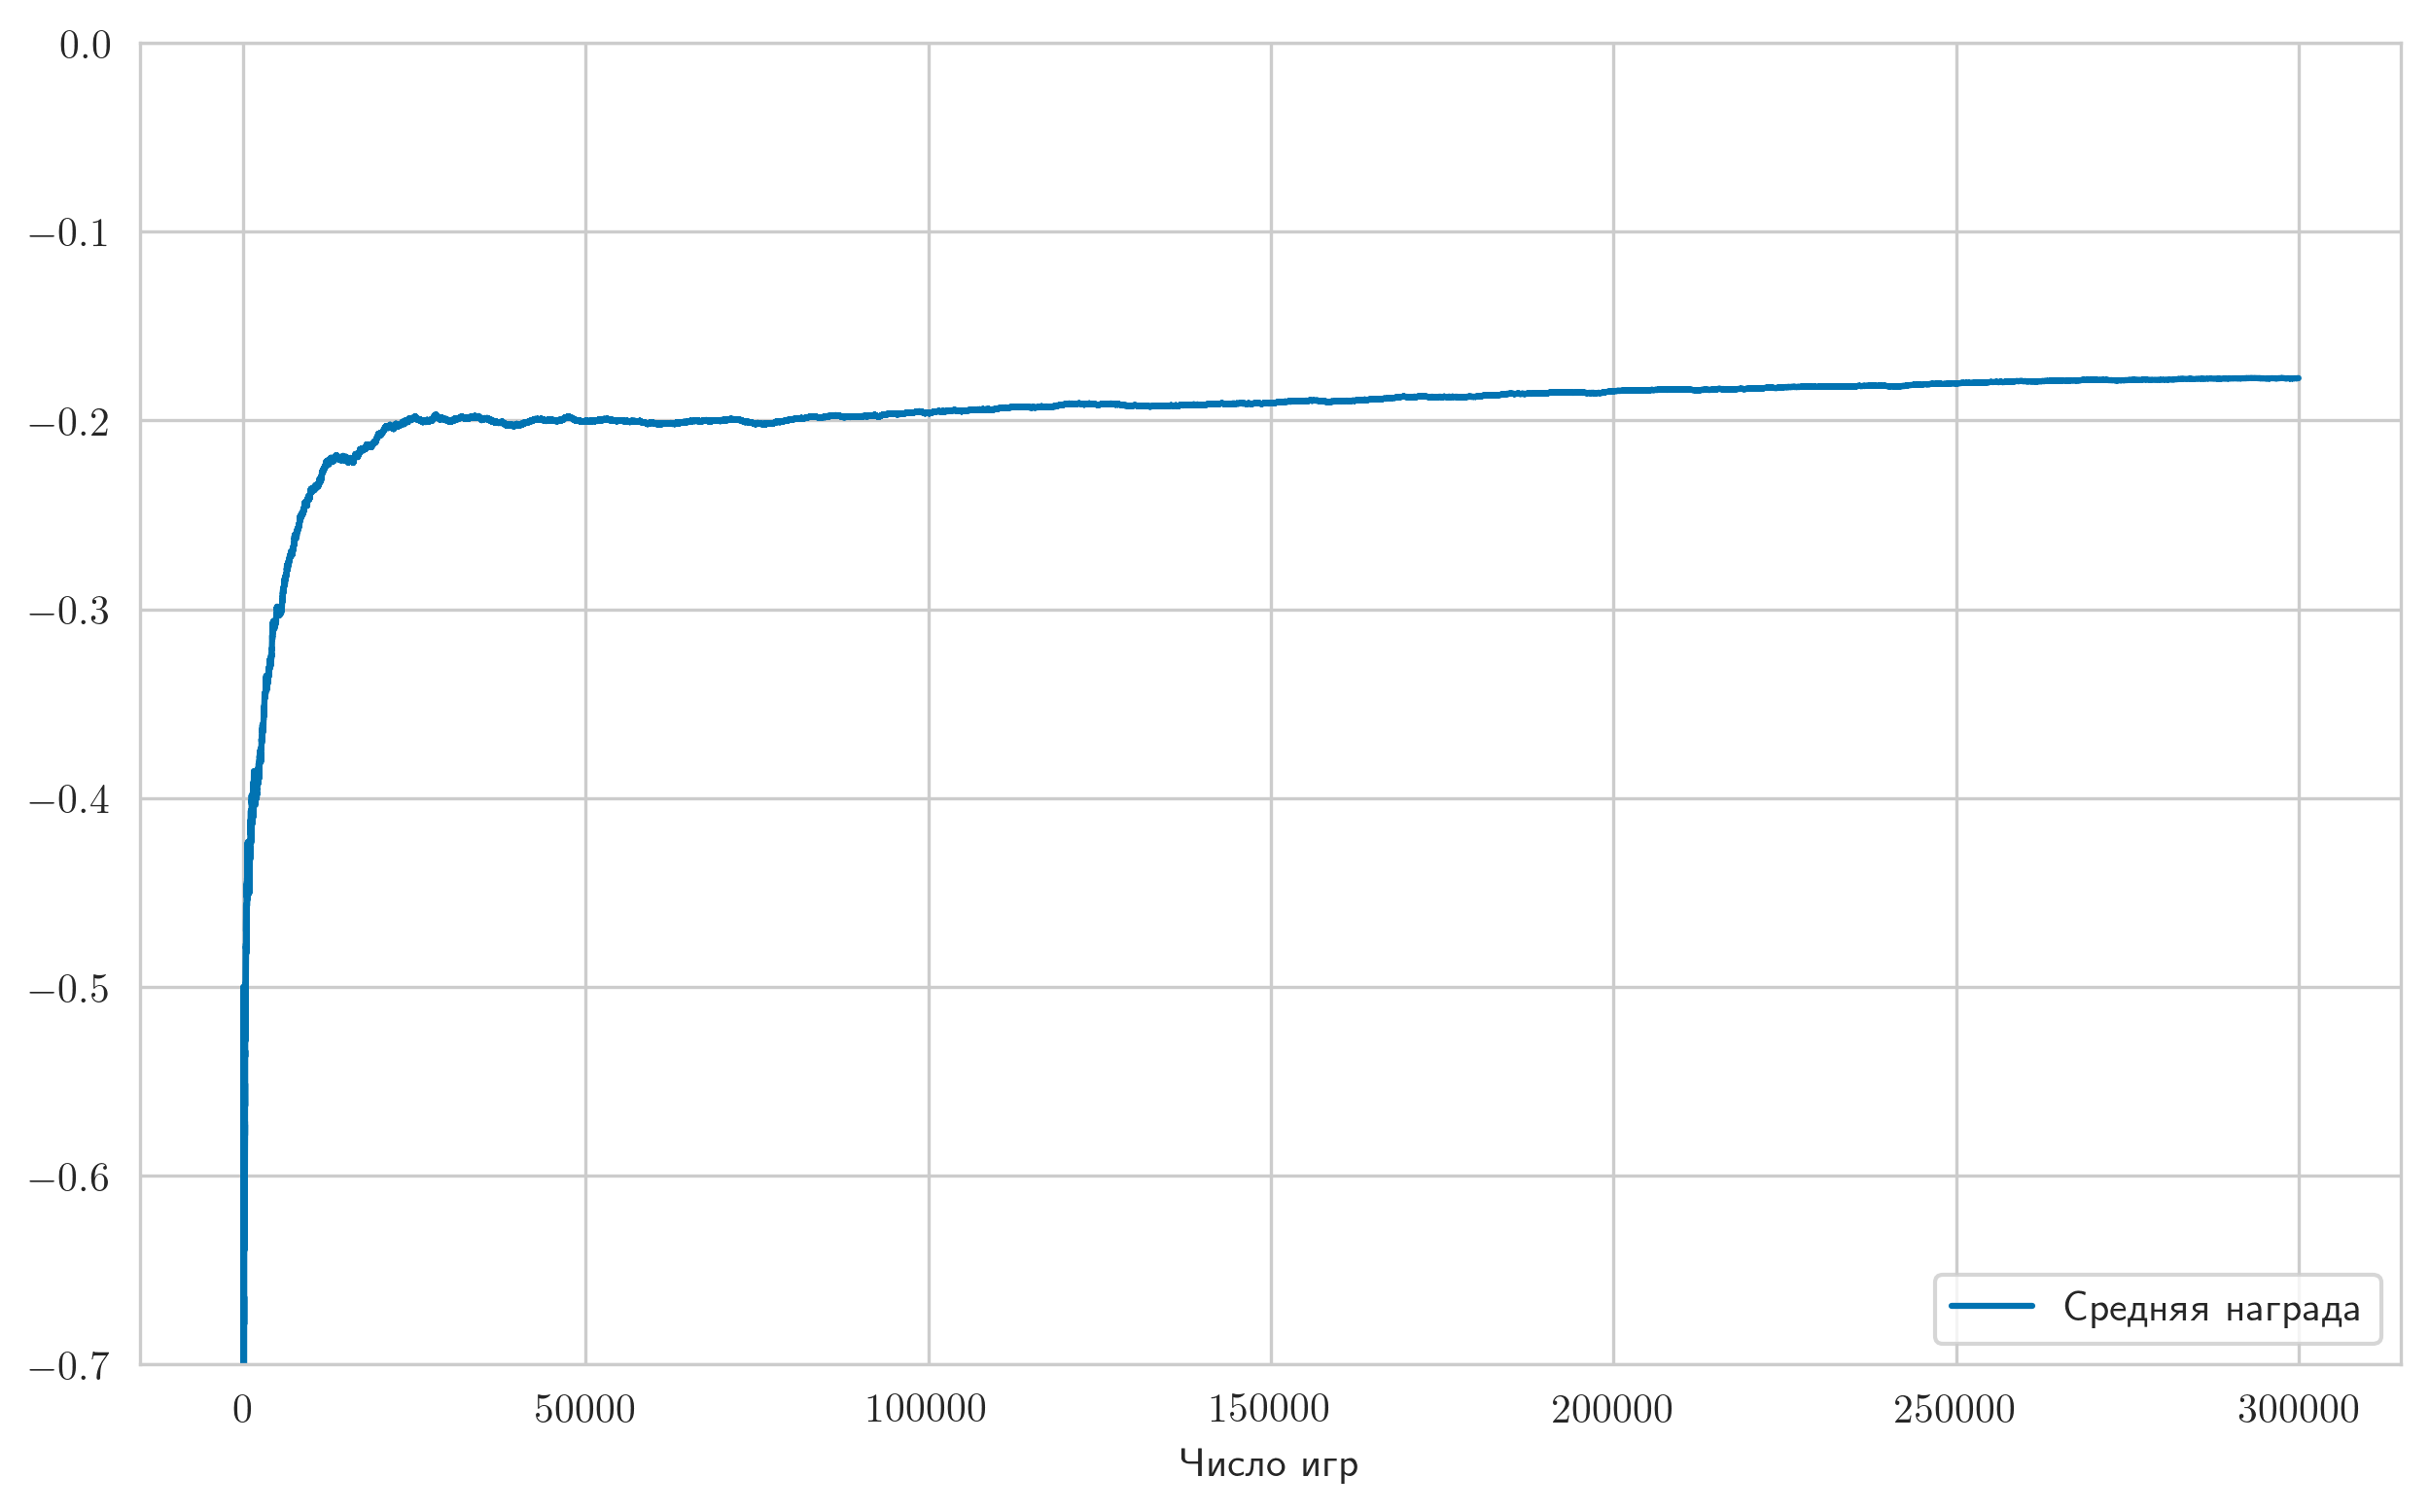

In [18]:
env = DoubleBlackjackEnv()
total_episodes = 300000
gamma = 0.9
alpha = 0.1
eps = 0.1


Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)

avg_results = [0]
for n in range(total_episodes + 1):
    if n > 0 and n % 30000 == 0:
        clear_output(True)
        print(n, " episodes completed")
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        line = ax.plot(np.arange(n), avg_results[1:], label="Средняя награда", color="C0")
        ax.legend(loc="lower right")
        ax.set_ylim((-0.7, 0.0))
        ax.set_xlabel('Число игр')
        plt.show()
    Q_learning_episode(env, pi, Q, alpha=alpha, epsilon= eps, gamma=gamma)
    pi = compute_policy_by_Q(env, Q)
    reward = reward_by_strategy_matrix(env, pi)
    avg_results.append((avg_results[-1] * n + reward) / (n + 1))

env.close()

In [19]:
print("Mean_profit: ", avg_results[-1])

Mean_profit:  -0.17759274135753003


## Эксперимент 2.
Зафиксируем параметры: gamma = 0.5, alpha = 0.05, epsilon = 0.2

300000  episodes completed


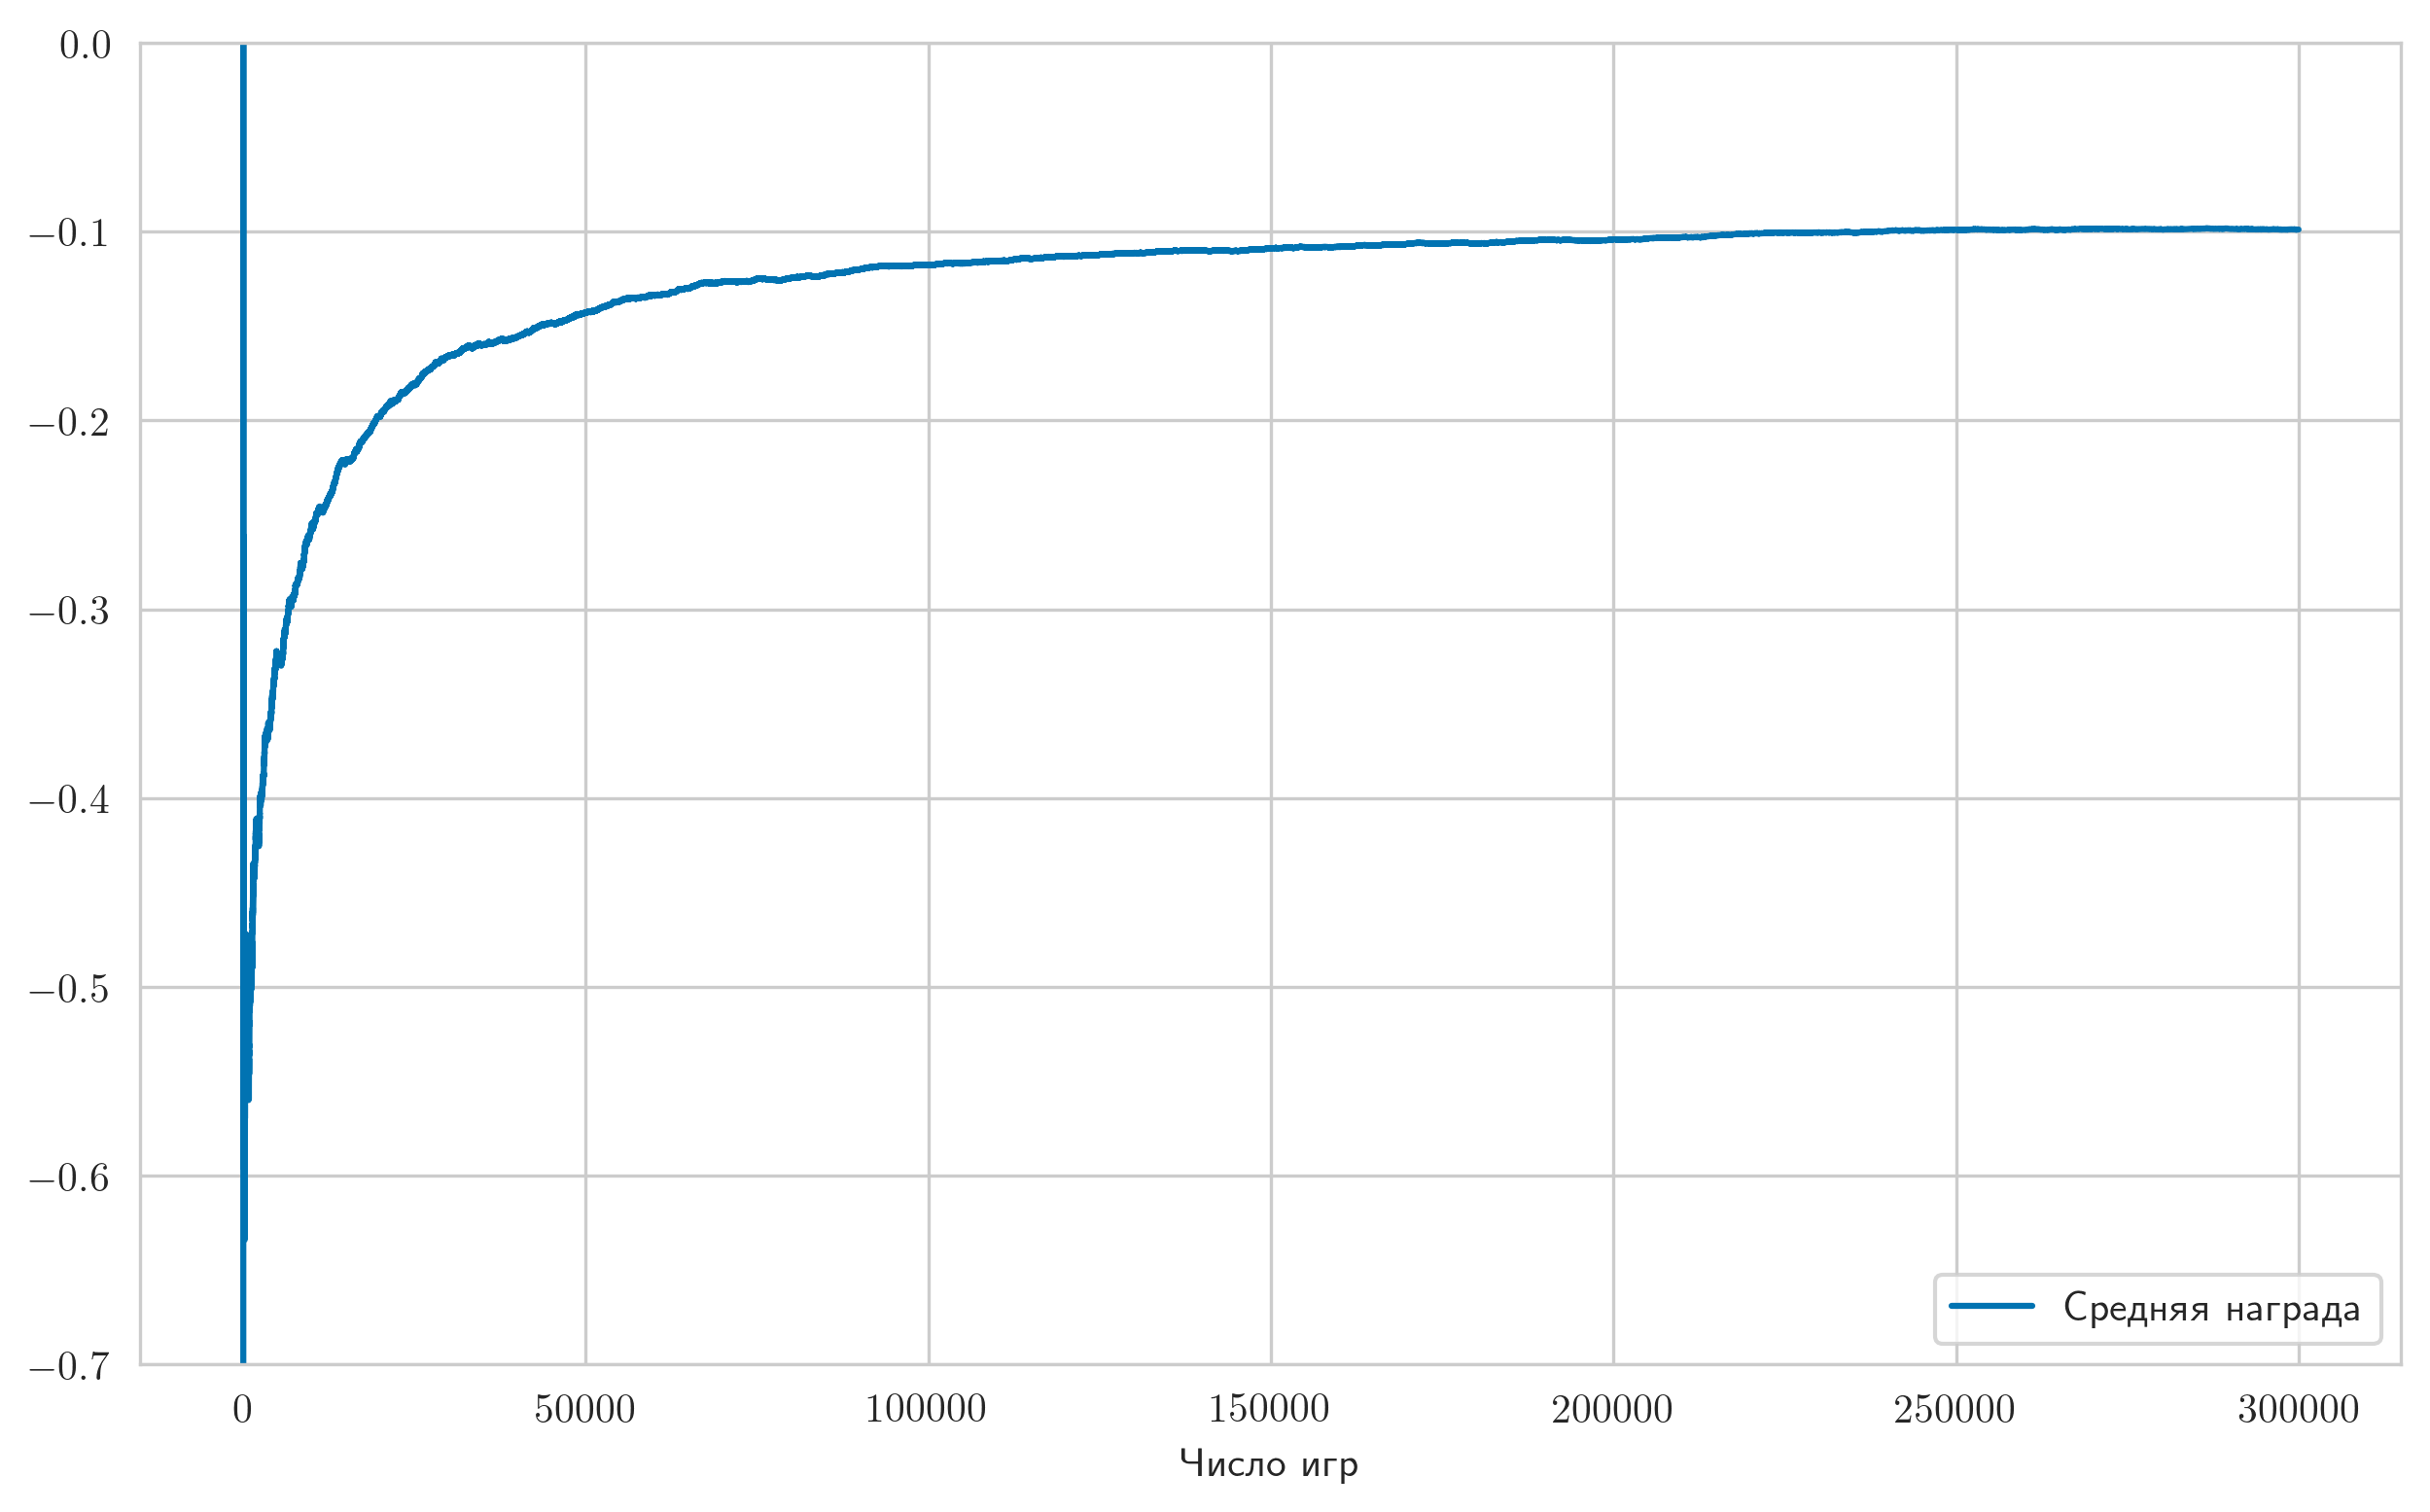

In [20]:
env = DoubleBlackjackEnv()
total_episodes = 300000
gamma = 0.5
alpha = 0.05
eps = 0.2


Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)

avg_results = [0]
for n in range(total_episodes + 1):
    if n > 0 and n % 30000 == 0:
        clear_output(True)
        print(n, " episodes completed")
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        line = ax.plot(np.arange(n), avg_results[1:], label="Средняя награда", color="C0")
        ax.legend(loc="lower right")
        ax.set_ylim((-0.7, 0.0))
        ax.set_xlabel('Число игр')
        plt.show()
    Q_learning_episode(env, pi, Q, alpha=alpha, epsilon= eps, gamma=gamma)
    pi = compute_policy_by_Q(env, Q)
    reward = reward_by_strategy_matrix(env, pi)
    avg_results.append((avg_results[-1] * n + reward) / (n + 1))

env.close()

In [21]:
print("Mean_profit: ", avg_results[-1])

Mean_profit:  -0.09888967036776626


## Эксперимент 3.
Зафиксируем параметры: gamma = 0.1, alpha = 0.05, epsilon = 0.5

300000  episodes completed


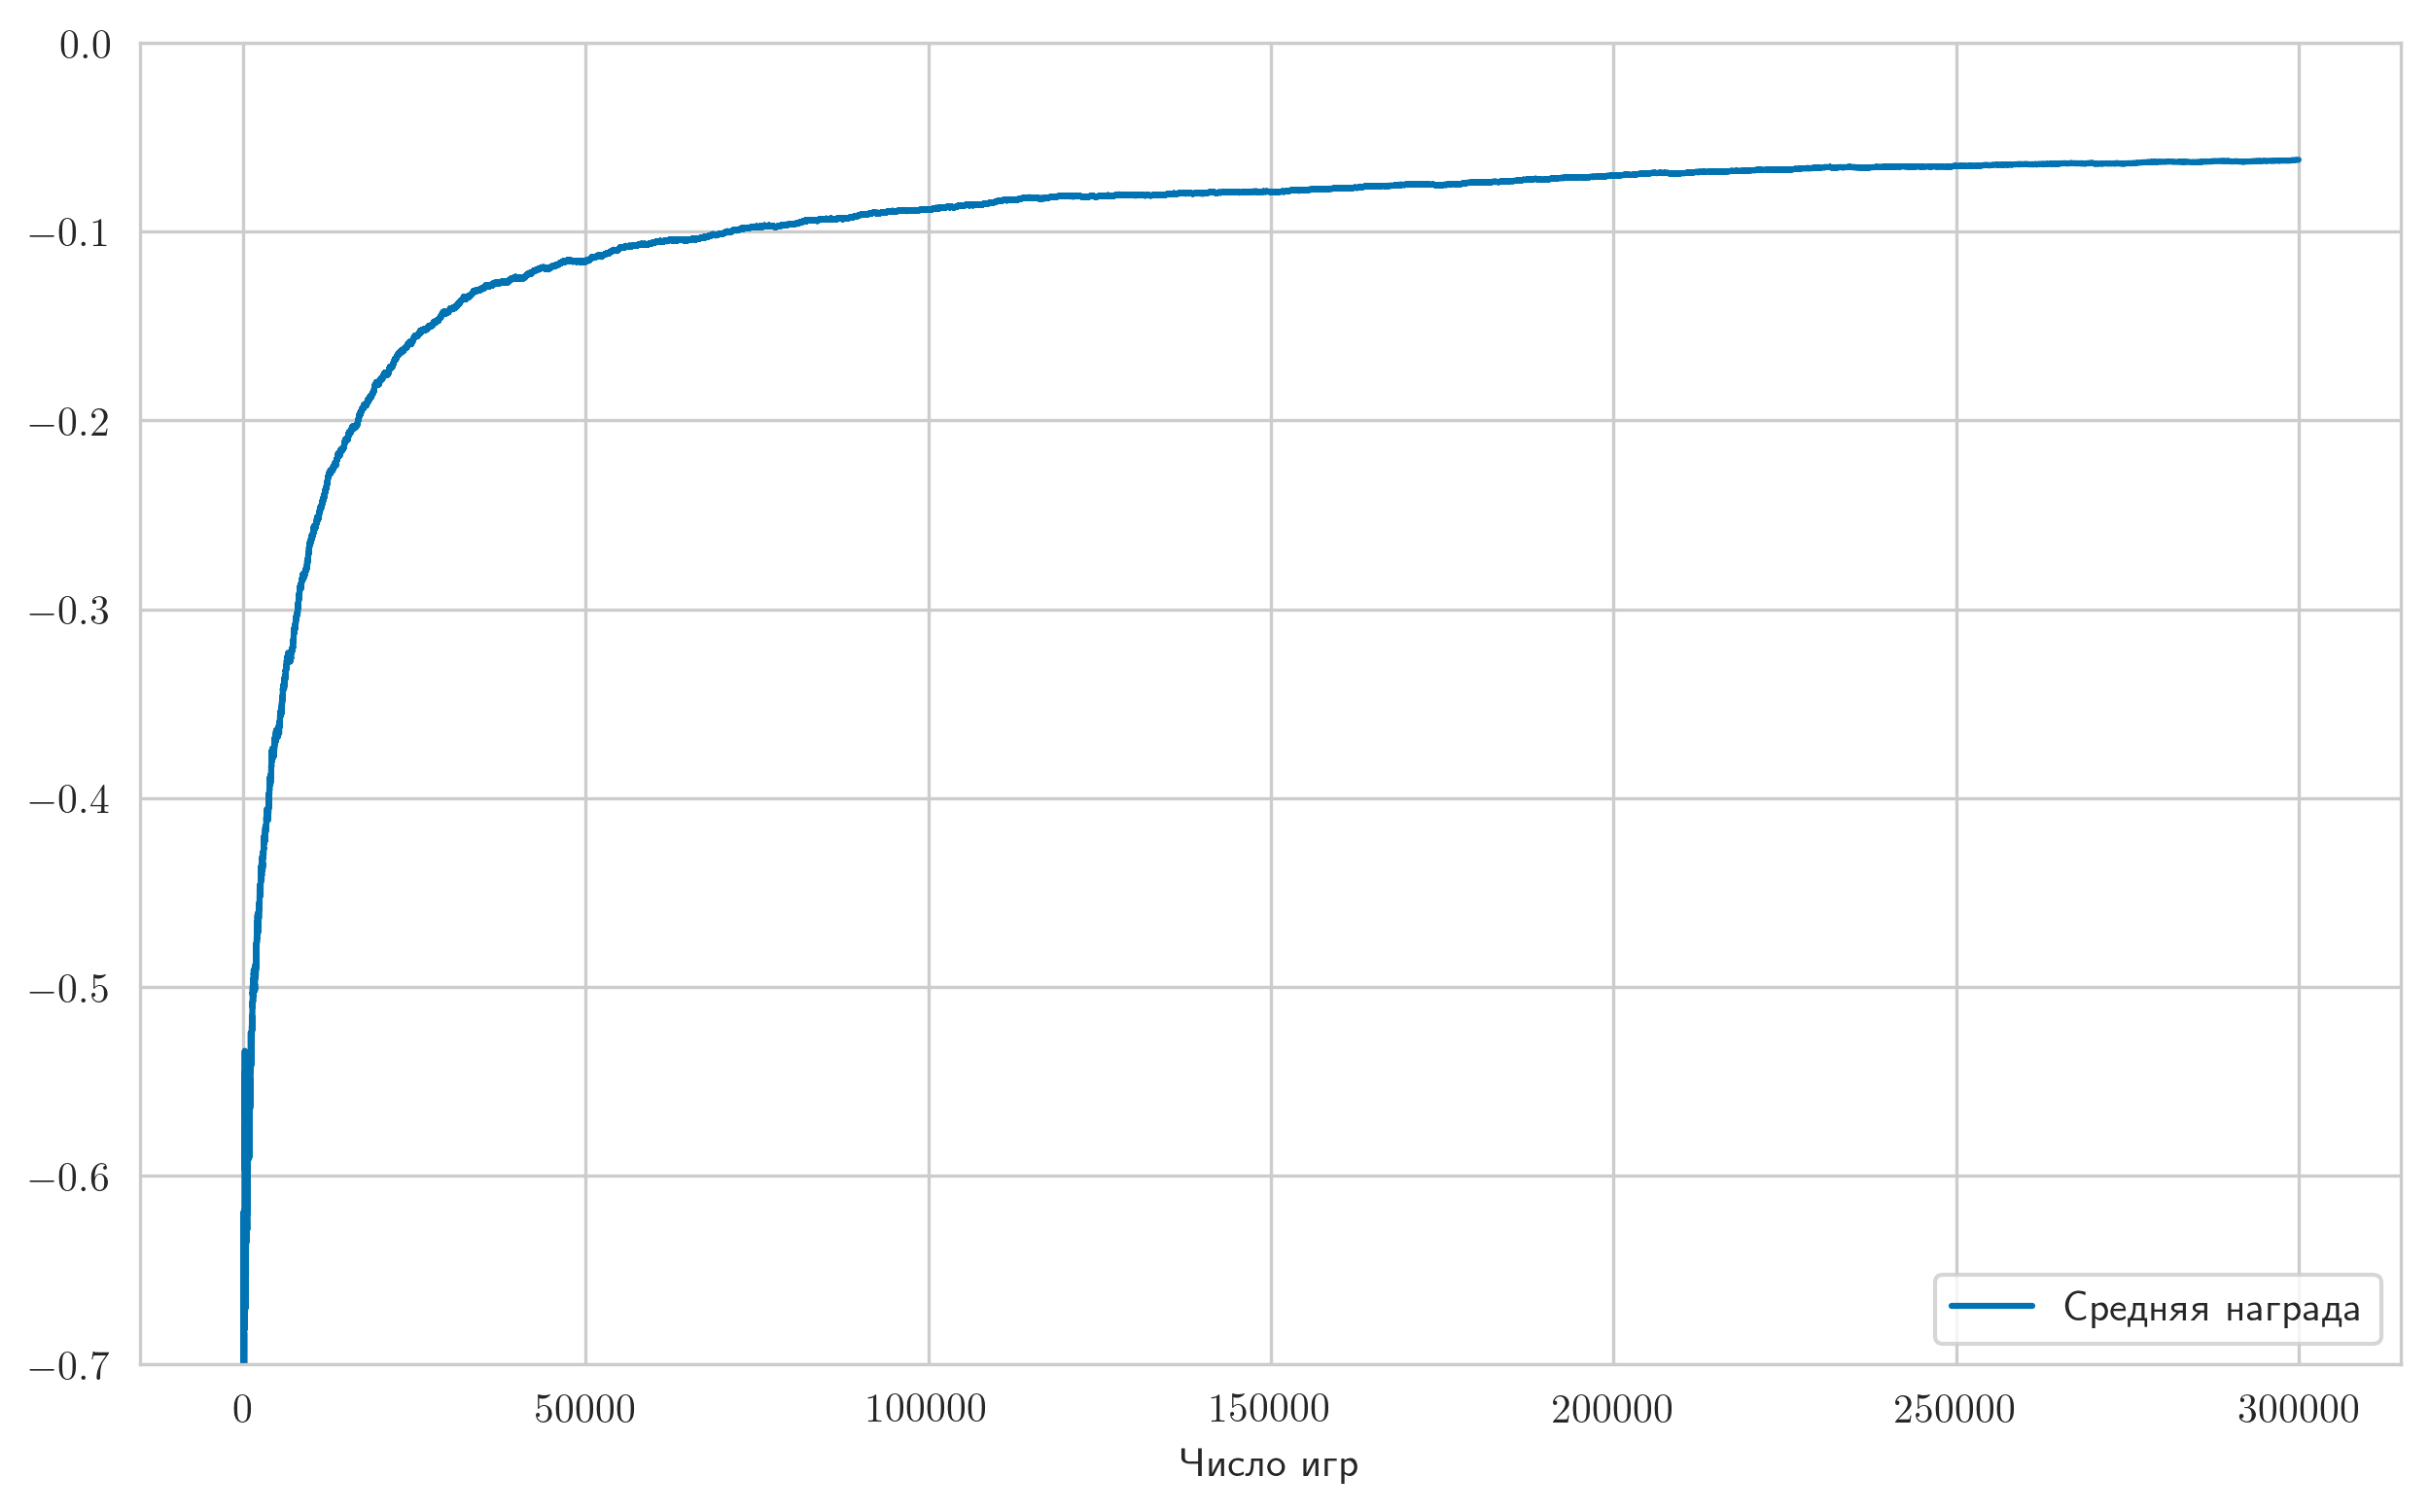

In [22]:
env = DoubleBlackjackEnv()
total_episodes = 300000
gamma = 0.1
alpha = 0.05
eps = 0.5


Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)

avg_results = [0]
for n in range(total_episodes + 1):
    if n > 0 and n % 30000 == 0:
        clear_output(True)
        print(n, " episodes completed")
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        line = ax.plot(np.arange(n), avg_results[1:], label="Средняя награда", color="C0")
        ax.legend(loc="lower right")
        ax.set_ylim((-0.7, 0.0))
        ax.set_xlabel('Число игр')
        plt.show()
    Q_learning_episode(env, pi, Q, alpha=alpha, epsilon= eps, gamma=gamma)
    pi = compute_policy_by_Q(env, Q)
    reward = reward_by_strategy_matrix(env, pi)
    avg_results.append((avg_results[-1] * n + reward) / (n + 1))

env.close()

In [23]:
print("Mean_profit: ", avg_results[-1])

Mean_profit:  -0.06193646021179848


По графикам видно, что результаты экспериментов аналогичны тем, что мы получили, когда мы играли в обычный блэкджек без удвоения. Обучение идет чуть медленнее, но так как пространство состояний увеличилось, то это вполне ожидаемо. 

В любом случае проигрывать меньше мы не стали, пора переходить к следующему столу...

## Часть 3. Играем как в кино и даже лучше.

Оставим возможность удвоения и дополнительно будем считать карты по системе "Половинки"(см. https://ru.wikipedia.org/wiki/Блэкджек). В фильме "Двадцать одно" тоже считали карты, но по более простой схеме: там не учитывалось в полной мере достоинство карт. Мы же будет вести счет, учитывая достоинство вышедших карт. Счет по закрытой карте дилера будем вести только после окончания раздачи, а то как-то не честно получается... 

Заметим, что максимальный и минимальный счет колоды при такой схеме 44 и -44 соответственно. Получим аж 89 состояний, но на самом деле встречаться будет в разы меньше, так как вероятность выпадения сначала всех картинок ничтожно мала. Несмотря на вышесказанное, не будем как-либо объединять слишком высокие или низкие счета, попробуем посчитать стратегию честно для каждого счета колоды.

Тем не менее, чтобы ускорить обучение, для каждого состояния счета колоды начнем процесс Q-обучения со стратегии, которую мы обучили в 3 эксперименте части 2. 

In [40]:
import gym
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

card_effects = {1 : -2,
                2 : 1,
                3 : 2,
                4 : 2,
                5 : 3,
                6 : 2,
                7 : 1,
                8 : 0,
                9 : -1,
                10 : -2}


def draw_card(np_random, dealer_second_draw = False):
    choice = np_random.choice(range(len(CountCardsBlackjackEnv.cur_deck)))
    card = CountCardsBlackjackEnv.cur_deck[choice]
    if not dealer_second_draw:
        CountCardsBlackjackEnv.cur_deck.pop(choice)
        CountCardsBlackjackEnv.cur_deck_state = CountCardsBlackjackEnv.cur_deck_state + card_effects[card]
    else:
        CountCardsBlackjackEnv.cur_deck.pop(choice)
        CountCardsBlackjackEnv.update_deck_state = card_effects[card]
    return int(card)


def draw_hand(np_random, dealer_draw = False):
    if not dealer_draw:
        return [draw_card(np_random), draw_card(np_random)]
    else:
        return [draw_card(np_random), draw_card(np_random, dealer_second_draw = True)]

def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class CountCardsBlackjackEnv(gym.Env):
    cur_deck = deck.copy()
    cur_deck_state = 0
    update_deck_state = 0

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(89), spaces.Discrete(2))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        else: # double: bid more - win more
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -2.0
            else:
                done = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))
        if done:
            CountCardsBlackjackEnv.cur_deck_state += CountCardsBlackjackEnv.update_deck_state
            CountCardsBlackjackEnv.update_deck_state = 0
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], CountCardsBlackjackEnv.cur_deck_state, usable_ace(self.player))

    def reset(self):
        if len(self.cur_deck) < 15:
            CountCardsBlackjackEnv.cur_deck = deck.copy()
            CountCardsBlackjackEnv.cur_deck_state = 0
        self.dealer = draw_hand(self.np_random, dealer_draw=True)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [41]:
def get_random_Q(env):
    Q = 2 * np.random.random(size=(env.observation_space[3].n, env.observation_space[2].n, env.observation_space[1].n, env.observation_space[0].n, env.action_space.n)) - 1
    for i in range(env.observation_space[2].n):
        Q[0,i] = Q_best_double[0].copy()
        Q[1,i] = Q_best_double[1].copy()
    return Q

def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    init_state = env.reset()
    s = (1 if init_state[3] else 0, init_state[2] + 44, init_state[1], init_state[0])
    a = pi[1 if init_state[3] else 0, init_state[2] + 44, init_state[1], init_state[0]] if np.random.rand() > epsilon else env.action_space.sample()
    for _ in range(1000):
        observation, reward, done, info = env.step(a)
        s_prime = (1 if observation[3] else 0, observation[2] + 44, observation[1], observation[0])
        a_prime = pi[1 if observation[3] else 0, observation[2] + 44, observation[1], observation[0]] if np.random.rand() > epsilon else env.action_space.sample()
        Q[s[0], s[1], s[2], s[3], a] += alpha * (reward + gamma * np.max(Q[s_prime[0], s_prime[1], s_prime[2], s_prime[3]]) - Q[s[0], s[1], s[2], s[3], a])
        s, a = s_prime, a_prime
        if done:
            break
            
def reward_by_strategy_matrix(env, pi):
    cur_state = env.reset()
    game_finished = False
    
    while not game_finished:
        cur_state, reward, game_finished, _ = env.step(pi[1 if cur_state[3] else 0, cur_state[2], cur_state[1], cur_state[0]])
    return reward

300000  episodes completed


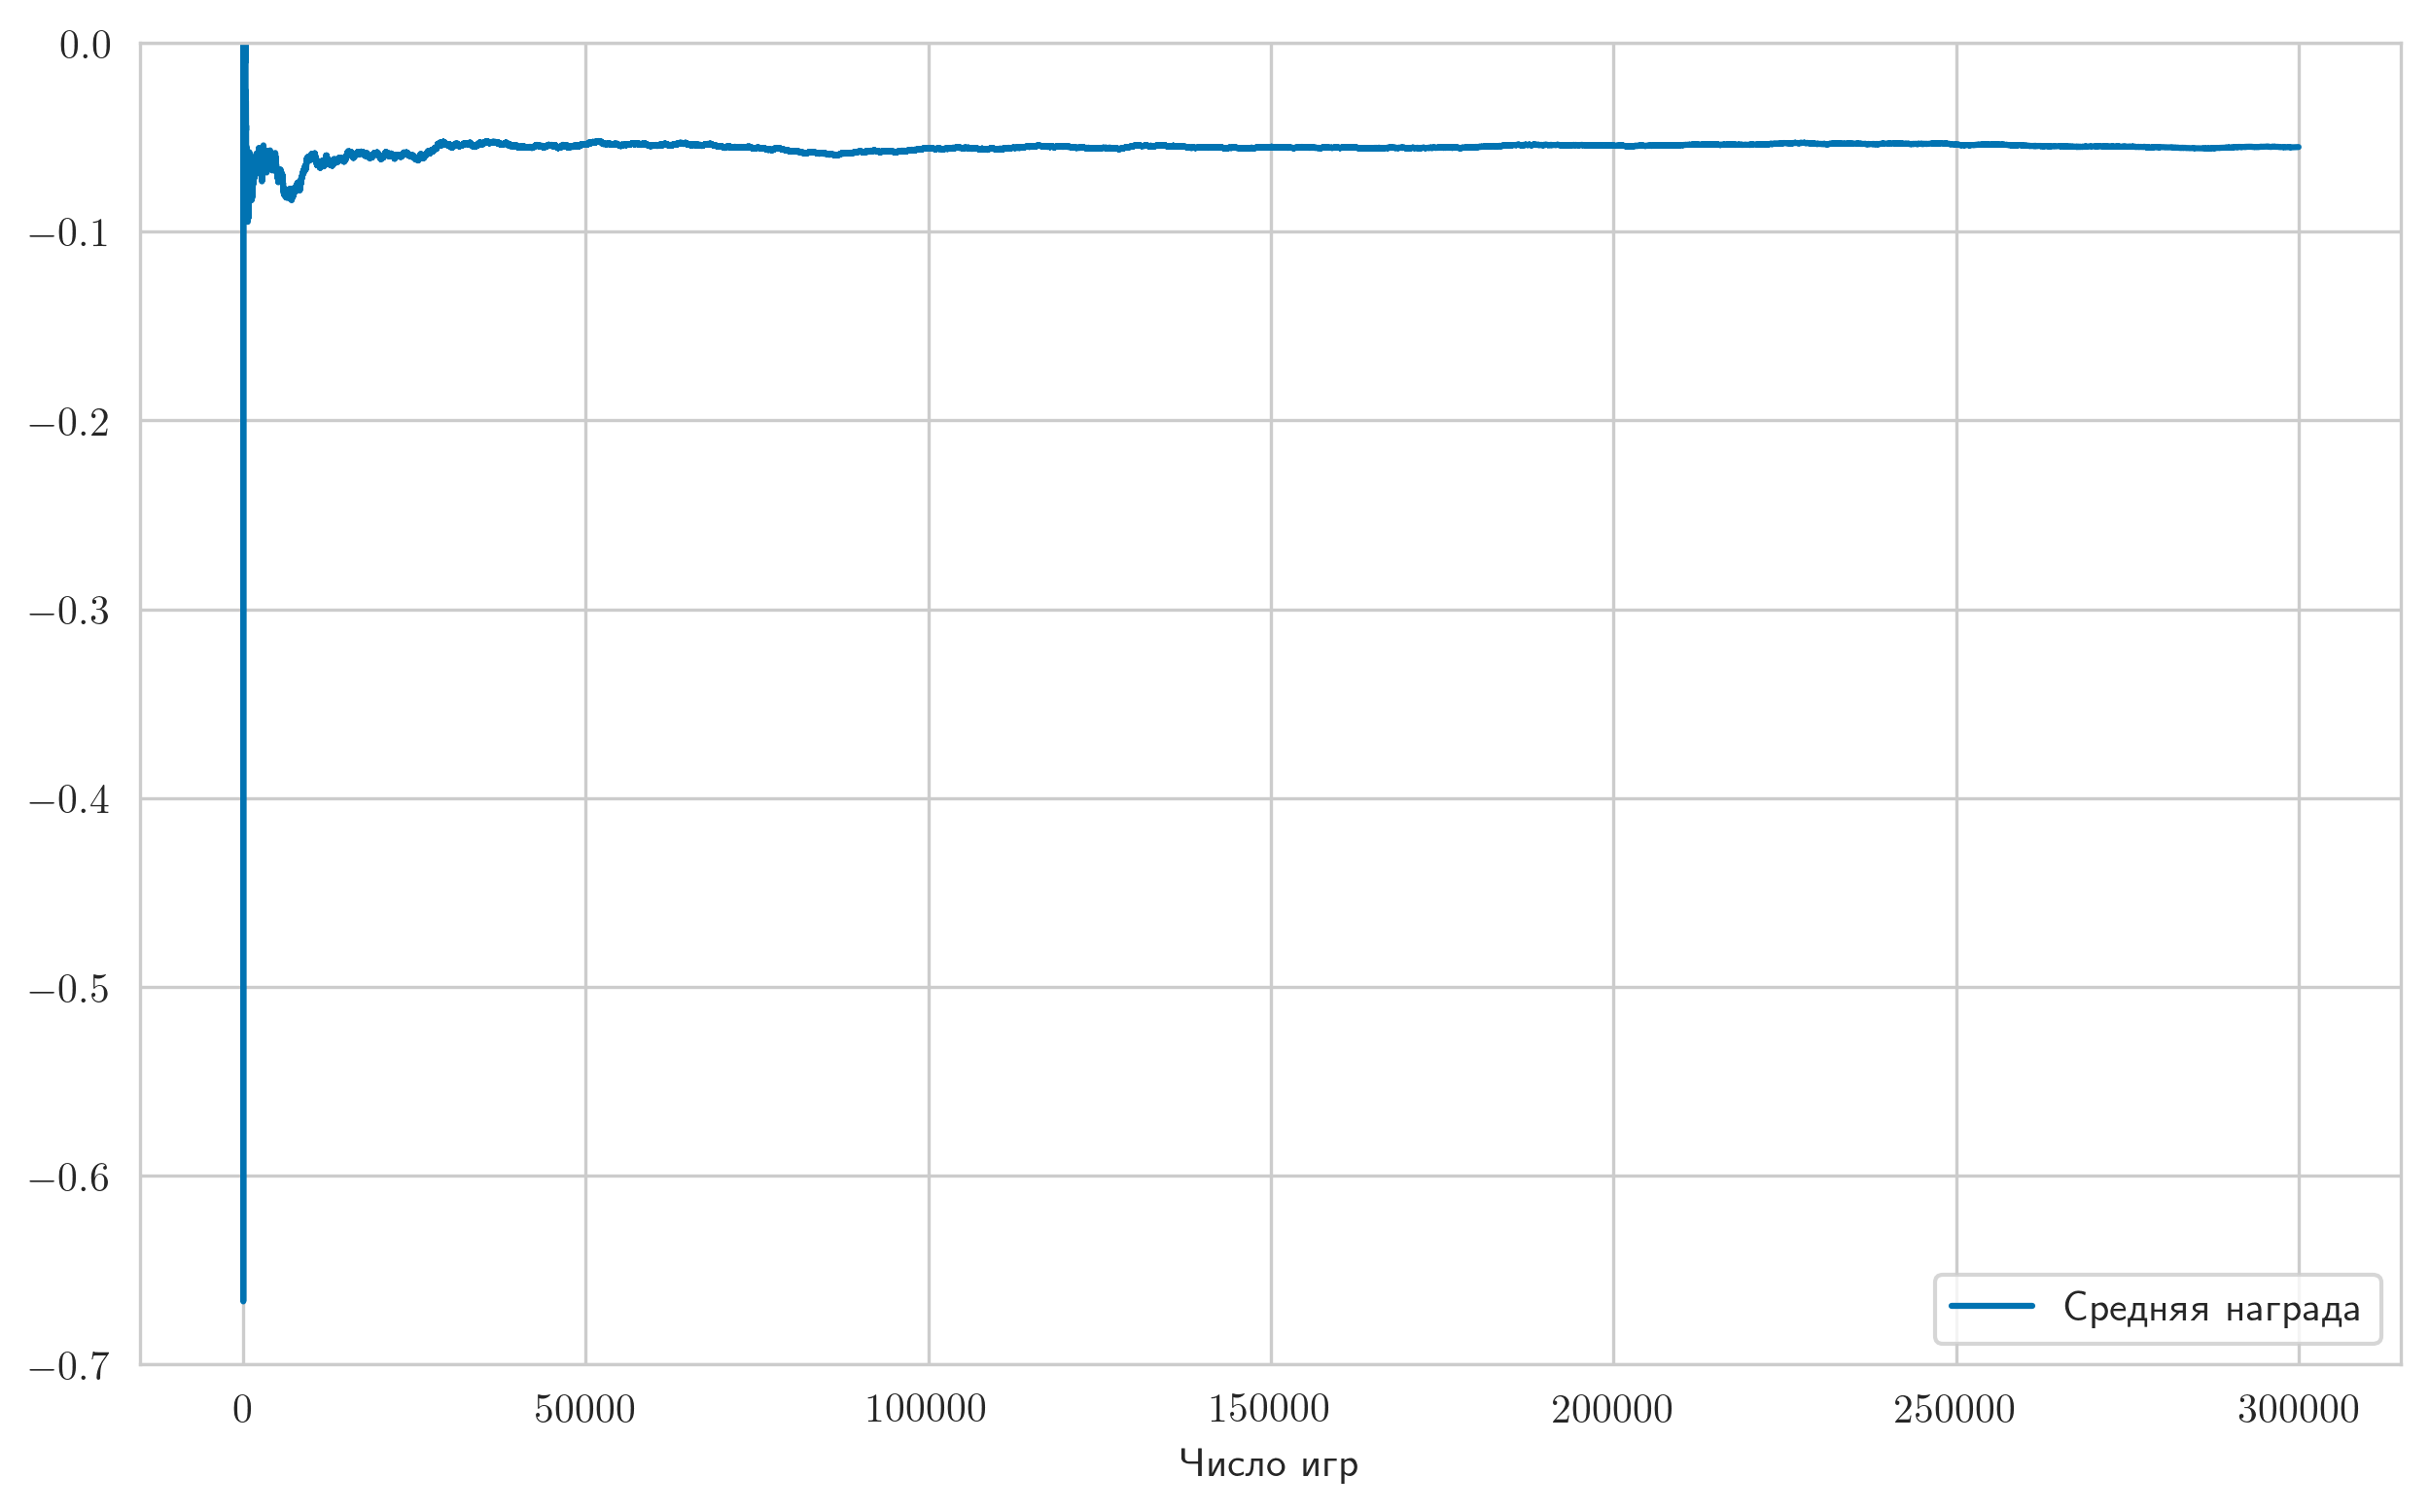

In [42]:
env = CountCardsBlackjackEnv()
CountCardsBlackjackEnv.cur_deck = deck.copy()
CountCardsBlackjackEnv.cur_deck_state = 0
total_episodes = 300000
gamma = 0.1
alpha = 0.05
eps = 0.5


Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)

avg_results = [0]
for n in range(total_episodes + 1):
    if n > 0 and n % 30000 == 0:
        clear_output(True)
        print(n, " episodes completed")
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        line = ax.plot(np.arange(n), avg_results[1:], label="Средняя награда", color="C0")
        ax.legend(loc="lower right")
        ax.set_ylim((-0.7, 0.0))
        ax.set_xlabel('Число игр')
        plt.show()
    Q_learning_episode(env, pi, Q, alpha=alpha, epsilon= eps, gamma=gamma)
    pi = compute_policy_by_Q(env, Q)
    reward = reward_by_strategy_matrix(env, pi)
    avg_results.append((avg_results[-1] * n + reward) / (n + 1))

env.close()

In [43]:
print("Mean_profit: ", avg_results[-1])

Mean_profit:  -0.05518314938950194


Казино обыграть не получилось, но подсчет карт внес еще небольшой профит в нашу стратегию. Теперь мы теряем около -0.055 у.е. на каждой раздаче